In [0]:
from __future__ import print_function, division

from keras.layers import Input, Dense, Flatten, Dropout, Reshape, Concatenate, UpSampling2D
from keras.layers import BatchNormalization, Activation, Conv2D, Conv2DTranspose, Dropout
from keras.layers.advanced_activations import LeakyReLU
from keras.models import Model
from keras.optimizers import Adam

from keras.datasets import cifar10
from tensorflow.examples.tutorials.mnist import input_data

import keras.backend as K

import matplotlib.pyplot as plt

import sys
import numpy as np
import time
from google.colab import files

%pylab inline

Using TensorFlow backend.


Populating the interactive namespace from numpy and matplotlib


In [0]:
def get_generator(input_layer, condition_layer):

  merged_input = Concatenate()([input_layer, condition_layer])
  
  dropout = 0.4
  depth = 64+64+64+64
  dim = 7
  
  hid = Dense(dim*dim*depth, input_dim=100)(merged_input)    
  hid = BatchNormalization(momentum=0.9)(hid)
  hid = Activation('relu')(hid)
  hid = Reshape((dim, dim, depth))(hid)
  hid = Dropout(dropout)(hid)

  hid = UpSampling2D()(hid)
  hid = Conv2DTranspose(int(depth/2),5,padding = "same")(hid)
  hid = BatchNormalization(momentum=0.9)(hid)
  hid = Activation("relu")(hid)
  
  hid = UpSampling2D()(hid)
  hid = Conv2DTranspose(int(depth/4), 5, padding='same')(hid)
  hid = BatchNormalization(momentum=0.9)(hid)
  hid = Activation('relu')(hid)
  
  hid = Conv2DTranspose(int(depth/8), 5, padding='same')(hid)
  hid = BatchNormalization(momentum=0.9)(hid)
  hid = Activation('relu')(hid)
  
  hid = Conv2DTranspose(1, 5, padding='same')(hid)
  out = Activation('sigmoid')(hid)

  model = Model(inputs=[input_layer, condition_layer], outputs=out)
  model.summary()
  
  return model, out


In [0]:
def get_discriminator(input_layer, condition_layer):
  
  depth = 64
  dropout = 0.4
  # In: 28 x 28 x 1, depth = 1
  # Out: 14 x 14 x 1, depth=64
  input_shape = (28, 28, 1)
  hid = Conv2D(depth*1, 5, strides=2, input_shape=input_shape,\
      padding='same')(input_layer)
  hid = LeakyReLU(alpha=0.2)(hid)
  hid = Dropout(dropout)(hid)

  hid = Conv2D(depth*2, 5, strides=2, padding='same')(hid)
  hid = LeakyReLU(alpha=0.2)(hid)
  hid = Dropout(dropout)(hid)

  hid = Conv2D(depth*4, 5, strides=2, padding='same')(hid)
  hid = LeakyReLU(alpha=0.2)(hid)
  hid = Dropout(dropout)(hid)

  hid = Conv2D(depth*8, 5, strides=1, padding='same')(hid)
  hid = LeakyReLU(alpha=0.2)(hid)
  hid = Dropout(dropout)(hid)

  # Out: 1-dim probability
  hid = Flatten()(hid)
  hid = Dense(1)(hid)
  out = Activation('sigmoid')(hid)
  
  model = Model(inputs=[input_layer, condition_layer], outputs=out)

  model.summary()

  return model, out

In [0]:
from keras.preprocessing import image

def one_hot_encode(y):
  z = np.zeros((len(y), 10))
  idx = np.arange(len(y))
  z[idx, y] = 1
  return z

def generate_noise(n_samples, noise_dim):
  X = np.random.normal(0, 1, size=(n_samples, noise_dim))
  return X

def generate_random_labels(n):
  y = np.random.choice(10, n)
  y = one_hot_encode(y)
  return y

tags = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
  
def show_samples(batchidx):
  fig, axs = plt.subplots(5, 6, figsize=(10,6))
  plt.subplots_adjust(hspace=0.3, wspace=0.1)
  #fig, axs = plt.subplots(5, 6)
  #fig.tight_layout()
  for classlabel in range(10):
    row = int(classlabel / 2)
    coloffset = (classlabel % 2) * 3
    lbls = one_hot_encode([classlabel] * 3)
    noise = generate_noise(3, 100)
    gen_imgs = generator.predict([noise, lbls])

    for i in range(3):
        # Dont scale the images back, let keras handle it
        img = image.array_to_img(gen_imgs[i], scale=True)
        axs[row,i+coloffset].imshow(img)
        axs[row,i+coloffset].axis('off')
        if i ==1:
          axs[row,i+coloffset].set_title(tags[classlabel])
  plt.show()
  plt.close()  

In [0]:
# GAN creation
img_input = Input(shape=(28,28,1))
disc_condition_input = Input(shape=(10,))

discriminator, disc_out = get_discriminator(img_input, disc_condition_input)
discriminator.compile(optimizer=Adam(0.0002, 0.5), loss='binary_crossentropy', metrics=['accuracy'])

discriminator.trainable = False

noise_input = Input(shape=(100,))
gen_condition_input = Input(shape=(10,))
generator, gen_out = get_generator(noise_input, gen_condition_input)

gan_input = Input(shape=(100,))
x = generator([gan_input, gen_condition_input])
gan_out = discriminator([x, disc_condition_input])
gan = Model(inputs=[gan_input, gen_condition_input, disc_condition_input], output=gan_out)
gan.summary()

gan.compile(optimizer=Adam(0.0002, 0.5), loss='binary_crossentropy')

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 64)        1664      
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 14, 14, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 7, 7, 128)         204928    
_________________________________________________________________
leaky_re_lu_2 (LeakyR

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:16: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Tensor("mo..., inputs=[<tf.Tenso...)`
  app.launch_new_instance()


In [0]:
BATCH_SIZE = 16

# # Get training images
X_train = input_data.read_data_sets("mnist", one_hot=True).train.images
y_train = input_data.read_data_sets("mnist", one_hot=True).train.labels

# Normalize data
#X_train = (X_train - 127.5) / 127.5
X_train = X_train.reshape(-1,28,28,1)

# 1hot encode labels
#y_train = one_hot_encode(y_train[:,0])

print ("Training shape: {}".format(X_train.shape))
 
num_batches = int(X_train.shape[0]/BATCH_SIZE)

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting mnist/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting mnist/train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Extracting mnist/t10k-images-idx3-ubyte.gz
Extracting mnist/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Extracting mnist/train-images-idx3-ubyte.gz
Extracting mnist/train-labels-idx1-ubyte.gz
Extracting mnist/t10k-images-idx3-ubyte.gz
Extracting mnist/t10k-labels-idx1-ubyte.gz
Training shape: (55000, 28, 28, 1)


In [0]:
# Array to store samples for experience replay
exp_replay = []

In [0]:
discriminator.load_weights("drive/My Drive/Projet OMA/discriminator_digits.h5")
generator.load_weights("drive/My Drive/Projet OMA/generator_digits.h5")

In [0]:
N_EPOCHS = 1000
start = time.time()
save_files = True
save_interval = 580
for epoch in range(N_EPOCHS):

  cum_d_loss = 0.
  cum_g_loss = 0.
  
  for batch_idx in range(num_batches):
    # Get the next set of real images to be used in this iteration
    images = X_train[batch_idx*BATCH_SIZE : (batch_idx+1)*BATCH_SIZE]
    labels = y_train[batch_idx*BATCH_SIZE : (batch_idx+1)*BATCH_SIZE]

    noise_data = generate_noise(BATCH_SIZE, 100)
    random_labels = generate_random_labels(BATCH_SIZE)
    # We use same labels for generated images as in the real training batch
    generated_images = generator.predict([noise_data, labels])

    # Train on soft targets (add noise to targets as well)
    noise_prop = 0.05 # Randomly flip 5% of targets
    
    # Prepare labels for real data
    true_labels = np.zeros((BATCH_SIZE, 1)) + np.random.uniform(low=0.0, high=0.1, size=(BATCH_SIZE, 1))
    flipped_idx = np.random.choice(np.arange(len(true_labels)), size=int(noise_prop*len(true_labels)))
    true_labels[flipped_idx] = 1 - true_labels[flipped_idx]
    
    # Train discriminator on real data
    d_loss_true = discriminator.train_on_batch([images, labels], true_labels)

    # Prepare labels for generated data
    gene_labels = np.ones((BATCH_SIZE, 1)) - np.random.uniform(low=0.0, high=0.1, size=(BATCH_SIZE, 1))
    flipped_idx = np.random.choice(np.arange(len(gene_labels)), size=int(noise_prop*len(gene_labels)))
    gene_labels[flipped_idx] = 1 - gene_labels[flipped_idx]
    
    # Train discriminator on generated data
    d_loss_gene = discriminator.train_on_batch([generated_images, labels], gene_labels)
    
    # Store a random point for experience replay
    r_idx = np.random.randint(BATCH_SIZE)
    exp_replay.append([generated_images[r_idx], labels[r_idx], gene_labels[r_idx]])
    
    #If we have enough points, do experience replay
    if len(exp_replay) == BATCH_SIZE:
      generated_images = np.array([p[0] for p in exp_replay])
      labels = np.array([p[1] for p in exp_replay])
      gene_labels = np.array([p[2] for p in exp_replay])
      expprep_loss_gene = discriminator.train_on_batch([generated_images, labels], gene_labels)
      exp_replay = []
      break
    
    d_loss = 0.5 * np.add(d_loss_true, d_loss_gene)
    cum_d_loss += d_loss

    # Train generator
    noise_data = generate_noise(BATCH_SIZE, 100)
    random_labels = generate_random_labels(BATCH_SIZE)
    g_loss = gan.train_on_batch([noise_data, random_labels, random_labels], np.zeros((BATCH_SIZE, 1)))
    cum_g_loss += g_loss

  print('\tEpoch: {}, Generator Loss: {}, Discriminator Loss: {}, Time: {}'.format(epoch+1, cum_g_loss/num_batches, cum_d_loss/num_batches, time.time()-start))
  show_samples("epoch" + str(epoch))
  
  if save_files and (epoch+1)%save_interval == 0:
    generator.save("drive/My Drive/Projet OMA/generator_digits.h5")
    discriminator.save("drive/My Drive/Projet OMA/discriminator_digits.h5")
    print("Models saved")


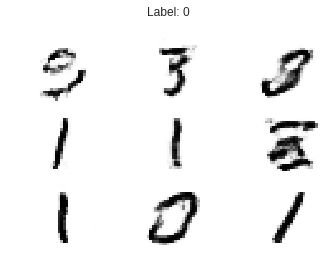

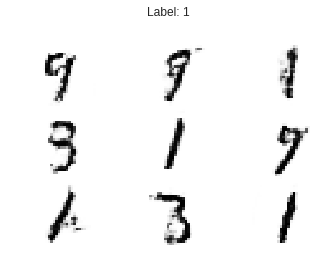

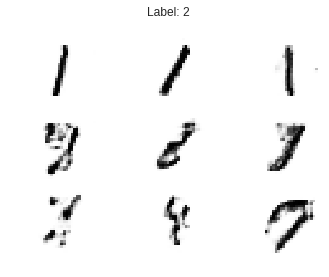

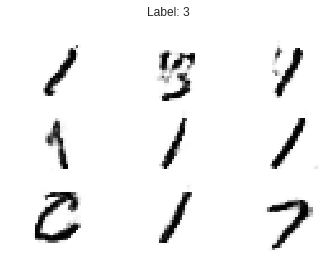

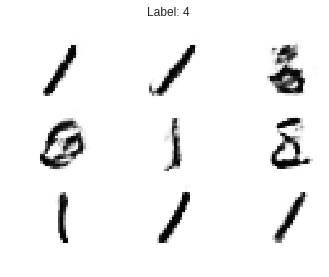

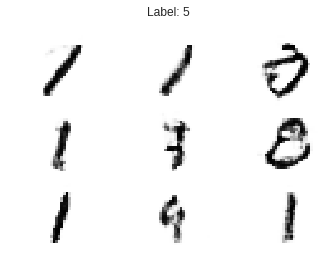

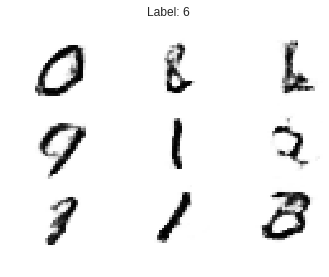

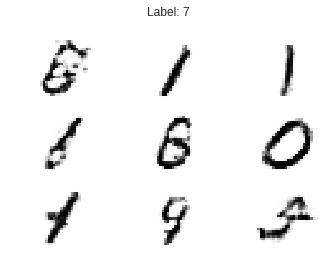

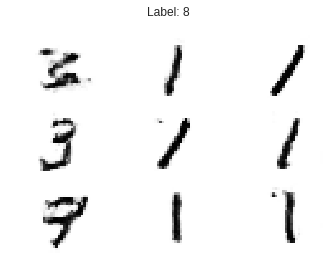

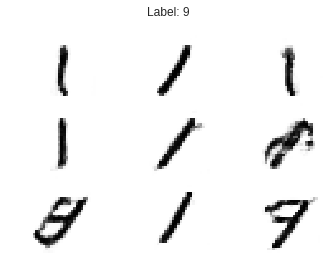

In [0]:
for classlabel in range(10):
  lbls = one_hot_encode([classlabel] * 9)
  noise = generate_noise(9, 100)
  gen_imgs = generator.predict([noise, lbls])

  fig, axs = plt.subplots(3, 3)
  plt.subplots_adjust(hspace=0.05, wspace=0.05)
  count = 0
  for i in range(3):
    for j in range(3):
      # Dont scale the images back, let keras handle it
      img = image.array_to_img(gen_imgs[count], scale=True)
      axs[i,j].imshow(img)
      axs[i,j].axis('off')
      plt.suptitle('Label: ' + str(classlabel))
      count += 1
  plt.show()
  plt.close()  

In [0]:
generator.save("drive/My Drive/Projet OMA/generator_digits.h5")
discriminator.save("drive/My Drive/Projet OMA/discriminator_digits.h5")

In [0]:
from google.colab import files



In [0]:
start = time.time()
files.download("discriminator.h5")
print(time.time()-start)
files.download("generator.h5")
print(time.time()-start)

72.2260348797
146.233091831


In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive
